In [59]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, LeakyReLU, Dropout, Reshape


# Creating an object detection model like YOLO, specialised in Traffic Road Object Detection

In [60]:
def create_model(input_shape, num_boxes=10, num_values_per_box=5):
    inputs = Input(shape=input_shape)

    # Example of a simple CNN architecture
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # add more layers here if necessary

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer with reshaping
    output = Dense(num_boxes * num_values_per_box)(x)
    output = Reshape((num_boxes, num_values_per_box))(output)

    model = Model(inputs=inputs, outputs=output)
    return model

In [61]:
# if using M1 Mac only
from tensorflow.keras.optimizers.legacy import Adam

In [62]:
# otherwise
# from tensorflow.keras.optimizers import Adam

In [63]:
# Adjust these parameters as necessary
input_shape = (416, 416, 3)
model = create_model(input_shape)

# Compile the model with an appropriate optimizer and loss function
model.compile(optimizer='adam', loss='mean_squared_error')  # Replace with your custom loss function as needed
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 416, 416, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 416, 416, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 208, 208, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 208, 208, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 104, 104, 64)      0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 692224)            0   

In [64]:
# loading the dataset and preprocessing
import os
import cv2
import numpy as np

def rescale_boxes(boxes, original_size, target_size):
    """
    Rescale bounding box coordinates based on new image size.

    :param boxes: List of boxes, each box is [class, x_center, y_center, width, height].
    :param original_size: Tuple of (width, height) of the original image.
    :param target_size: Tuple of (width, height) of the resized image.
    :return: Rescaled boxes.
    """
    ox_width, ox_height = original_size
    tx_width, tx_height = target_size

    scale_x = tx_width / ox_width
    scale_y = tx_height / ox_height

    rescaled_boxes = []
    for box in boxes:
        class_label, x_center, y_center, width, height = box
        x_center = x_center * scale_x
        y_center = y_center * scale_y
        width = width * scale_x
        height = height * scale_y
        rescaled_boxes.append([class_label, x_center, y_center, width, height])

    return rescaled_boxes


def load_data(image_directory, label_directory, original_size=(1920, 1080), target_size=(416, 416)):
    images = []
    labels = []

    # Iterate through each file in the image directory
    for filename in os.listdir(image_directory):
        if filename.endswith('.jpg'):
            image_path = os.path.join(image_directory, filename)
            label_path = os.path.join(label_directory, filename.replace('.jpg', '.txt'))

            # Load and resize the image
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, target_size)
            images.append(image)

            # Read and process the corresponding label file
            label = []
            with open(label_path, 'r') as file:
                for line in file:
                    class_label, x_center, y_center, width, height = map(float, line.split())
                    label.append([class_label, x_center, y_center, width, height])

            # Rescale the boxes based on the image size change
            rescaled_label = rescale_boxes(label, original_size, target_size)
            labels.append(rescaled_label)

    # Convert labels to a fixed size array, pad with zeros if necessary
    max_boxes_per_image = 10  # Set this to the maximum number of boxes you expect in any image
    padded_labels = []

    for label in labels:
        padded_label = np.zeros((max_boxes_per_image, 5))  # 5 for class, x_center, y_center, width, height
        padded_label[:len(label)] = label[:max_boxes_per_image]
        padded_labels.append(padded_label)

    return np.array(images), np.array(padded_labels)

# Testing the preprocessing function on a single image

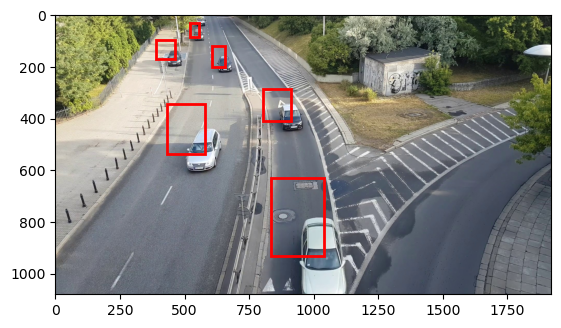

In [95]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def display_image_with_boxes(image_path, boxes):
    """
    Display an image with bounding boxes.

    :param image_path: Path to the image.
    :param boxes: List of bounding boxes, each box is [x_center, y_center, width, height].
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create a figure and axis for display
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Add the bounding boxes
    for box in boxes:
        x_center, y_center, width, height = box
        # Convert center coordinates to top-left coordinates
        x = x_center - width / 2
        y = y_center - height / 2
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()
def unnormalize(normalized_box):
    """
    Convert a normalized bounding box into pixel coordinates.

    :param normalized_box: Normalized bounding box, each box is [x_center, y_center, width, height].
    :return: Bounding box in pixel coordinates, each box is [x_top_left, y_top_left, width, height].
    """
    # Set the original image size
    image_height = 1080
    image_width = 1920

    # Convert to pixel coordinates
    x_center_px = normalized_box[0] * image_width
    y_center_px = normalized_box[1] * image_height
    width_px = normalized_box[2] * image_width
    height_px = normalized_box[3] * image_height

    # Convert from center coordinates to top-left coordinates
    x_top_left = x_center_px - (width_px / 2)
    y_top_left = y_center_px - (height_px / 2)

    pixel_box = [x_top_left, y_top_left, width_px, height_px]
    return pixel_box

values = [[0.240365, 0.156019, 0.036979, 0.067593],
[0.542188, 0.861111, 0.107292, 0.277778],
[0.301563, 0.497222, 0.077083, 0.179630],
[0.474219, 0.380093, 0.054688, 0.115741],
[0.342969, 0.183333, 0.027604, 0.074074],
[0.290365, 0.078704, 0.018229, 0.050000]]

for i in range(len(values)):
    pixel_box = unnormalize(values[i])
    values[i] = pixel_box
# Example usage
image_path = './frame_0399.jpg'

display_image_with_boxes(image_path, values)


In [65]:
import tensorflow as tf

train_images, train_labels = load_data('archive/train/images/', 'archive/train/labels/')
val_images, val_labels = load_data('archive/val/images/', 'archive/val/labels/')

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

# Optional: Batch and prefetch
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [66]:
model.fit(train_dataset, epochs=10, validation_data=val_dataset, batch_size=32)

Epoch 1/10
13/13 [==============================] - 8s 501ms/step - loss: 27331618.0000 - val_loss: 101246.4688
Epoch 2/10
13/13 [==============================] - 4s 327ms/step - loss: 186406.0938 - val_loss: 4121.0889
Epoch 3/10
13/13 [==============================] - 4s 329ms/step - loss: 14761.8760 - val_loss: 1096.1354
Epoch 4/10
13/13 [==============================] - 5s 358ms/step - loss: 6806.7285 - val_loss: 783.1789
Epoch 5/10
13/13 [==============================] - 4s 321ms/step - loss: 5695.9736 - val_loss: 718.3894
Epoch 6/10
13/13 [==============================] - 4s 297ms/step - loss: 5438.1372 - val_loss: 695.4465
Epoch 7/10
13/13 [==============================] - 4s 289ms/step - loss: 5340.5688 - val_loss: 609.4615
Epoch 8/10
13/13 [==============================] - 4s 283ms/step - loss: 5229.9077 - val_loss: 625.3583
Epoch 9/10
13/13 [==============================] - 4s 280ms/step - loss: 5245.0591 - val_loss: 607.1381
Epoch 10/10
13/13 [========================

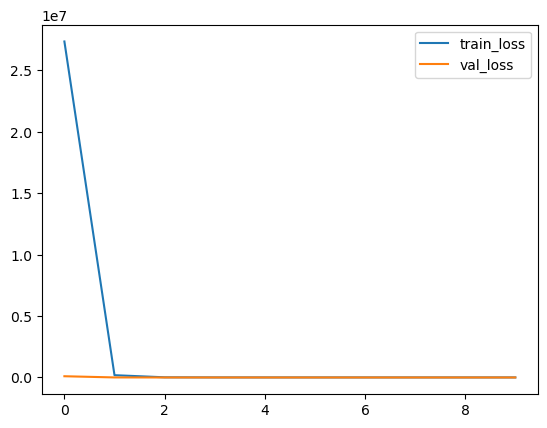

In [67]:
# plotting the loss
import matplotlib.pyplot as plt

plt.plot(model.history.history['loss'], label='train_loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()

In [68]:
# saving the model
model.save('model.keras')

# Predicting bounding boxes on a batch of images

In [100]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def display_image_with_boxes(image, boxes, image_size):
    """
    Display an image with bounding boxes.

    :param image_path: Path to the image.
    :param boxes: List of bounding boxes, each box is [x_center, y_center, width, height] in normalized coordinates.
    :param image_size: Tuple of (width, height) of the image.
    """

    img_height, img_width = image_size

    # Create a figure and axis for display
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Add the bounding boxes
    for box in boxes:
        x_center, y_center, width, height = box

        # Convert from normalized to pixel coordinates
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height

        # Convert center coordinates to top-left coordinates
        x = x_center - width / 2
        y = y_center - height / 2
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

In [103]:
from tensorflow.keras.models import load_model

# Load the trained model
model_path = 'model.keras'
model = load_model(model_path, compile=False)
model.compile(optimizer='adam', loss='mean_squared_error')

In [106]:
def preprocess_image(image_path, target_size):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize if your model expects this
    return image

# Example usage
image_path = './frame_0399.jpg'
target_size = (416, 416)  # The input size your model expects
processed_image = preprocess_image(image_path, target_size)


In [116]:
# Expand dimensions to match the model's input format
image_batch = np.expand_dims(processed_image, axis=0)

# Get predictions
predictions = model.predict(image_batch)

# Print the raw predictions to understand the format
print("Raw predictions:", predictions)


1/1 [==============================] - 0s 13ms/step
Raw predictions: [[[ 0.01861222  0.07748249  0.09306006  0.11260021 -0.10079251]
  [-0.12515046  0.0267153  -0.06610255 -0.0116725   0.07593858]
  [-0.07126859  0.04640125  0.1819029   0.01477832  0.11258684]
  [ 0.18325368  0.00897343 -0.12763917 -0.01153657 -0.12306613]
  [ 0.10900097 -0.02300651  0.03412749 -0.03848829 -0.04781757]
  [ 0.12305628 -0.0158443   0.08274628  0.00248155  0.19094856]
  [ 0.06478558 -0.04786042  0.03722904  0.0197549  -0.05255729]
  [ 0.02107287 -0.06355258 -0.06779058 -0.06025025  0.07809964]
  [ 0.16085355 -0.05507242  0.07508186 -0.00193774  0.04654707]
  [ 0.08012095  0.07219569  0.06068757  0.02109296 -0.06049979]]]


In [117]:
# Assuming the first four values are normalized coordinates and the fifth is a confidence score
for i in range(predictions.shape[1]):  # Loop over each predicted box
    box = predictions[0, i, :4]  # Extract the bounding box coordinates
    confidence = predictions[0, i, 4]  # Extract the confidence score

    # You might need to apply a sigmoid function if the confidence is not between 0 and 1
    #confidence = 1 / (1 + np.exp(-confidence))

    # Thresholding by confidence score (adjust the threshold as needed)
    if confidence > 0.5:  # Example threshold
        print(f"Box {i}: {box}, Confidence: {confidence}")


Number of boxes detected: 0


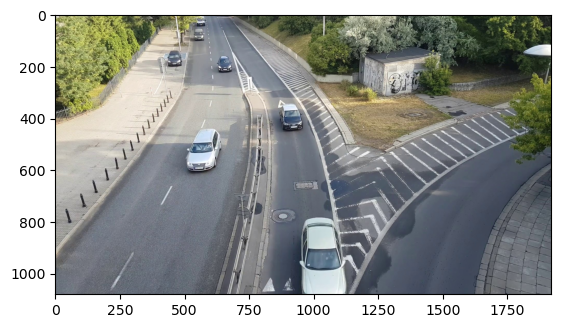

In [120]:
# Example image properties
image_path = './frame_0399.jpg'
original_image_size = (1920, 1080)  # Replace with the actual size of your image

# Extract boxes with confidence > threshold
boxes_to_display = [predictions[0, i, :4] for i in range(predictions.shape[1]) if predictions[0, i, 4] > 0.5]

# print the number of boxes detected
print(f"Number of boxes detected: {len(boxes_to_display)}")

# Display the image with the boxes
display_image_with_boxes(image_path, boxes_to_display, original_image_size)
